<a href="https://colab.research.google.com/github/neosavvy/hodl-coastguard/blob/main/HODL_Project_Boat_Not_Boat_V03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# initialize the seeds of different random number generators so that the 
# results will be the same every time the notebook is run
keras.utils.set_random_seed(42)

In [ ]:
!wget -q -P ./ https://www.dropbox.com/s/61lc3ms9tlm5xvd/Boat-Not_Boat.zip?dl=0
!unzip -qq Boat-Not_Boat.zip?dl=0

In [ ]:
#!rm -rf //content/Boat-Not_Boat 

In [ ]:
import os, shutil, pathlib

base_dir = pathlib.Path("/content/Boat-Not_Boat")



In [ ]:
for category in ('Boat', 'Not Boat'):
  fnames = os.listdir(base_dir/category)
  dir = base_dir /'train' / category
  os.makedirs(dir)
  for fname in fnames[:50]:
      shutil.copyfile(src=base_dir/category/fname,
                      dst=dir/fname)
  dir = base_dir /'validation' / category
  os.makedirs(dir)
  for fname in fnames[50:75]:
      shutil.copyfile(src=base_dir/category/fname,
                      dst=dir/fname)
  dir = base_dir /'test' / category
  os.makedirs(dir)
  for fname in fnames[75:]:
      shutil.copyfile(src=base_dir/category/fname,
                      dst=dir/fname)

In [ ]:
train_dataset = keras.utils.image_dataset_from_directory(
    base_dir / 'train',
    image_size=(224, 224),
    batch_size=32)

validation_dataset = keras.utils.image_dataset_from_directory(
    base_dir / 'validation',
    image_size=(224, 224),
    batch_size=32)

test_dataset = keras.utils.image_dataset_from_directory(
    base_dir / 'test',
    image_size=(224, 224),
    batch_size=32)

Found 100 files belonging to 2 classes.
Found 50 files belonging to 2 classes.
Found 80 files belonging to 2 classes.


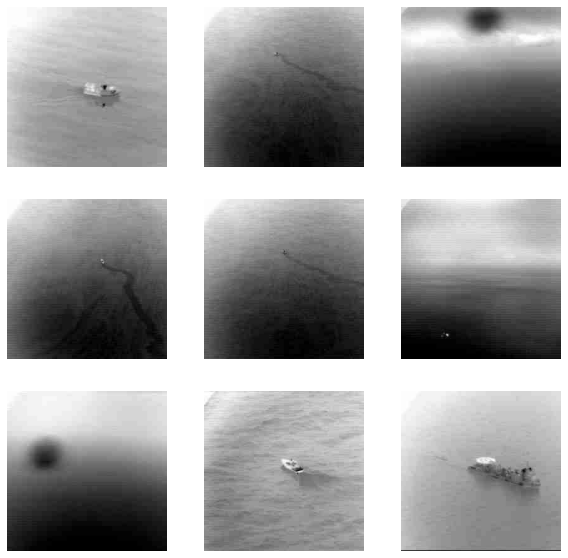

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomZoom(0.2),
    ]
)

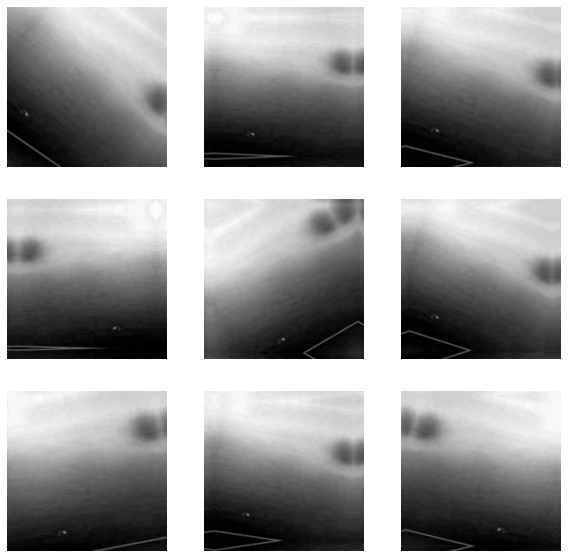

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[1].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
resnet50_base = keras.applications.ResNet50(
  weights='imagenet',
  include_top=False,
  input_shape=(224, 224, 3))

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:

#model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
#model.eval();

In [ ]:
def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images, labels in dataset:
    preprocessed_images = keras.applications.resnet50.preprocess_input(images)
    features = resnet50_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)

In [ ]:
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [ ]:
train_features.shape

(100, 7, 7, 2048)

In [ ]:
input = keras.Input(shape=(7, 7, 2048))
h = keras.layers.Flatten()(input)
h = keras.layers.Dense(256, activation="relu")(h)
h = keras.layers.Dropout(0.5)(h)
output = keras.layers.Dense(1, activation="sigmoid")(h)

model = keras.Model(input, output)

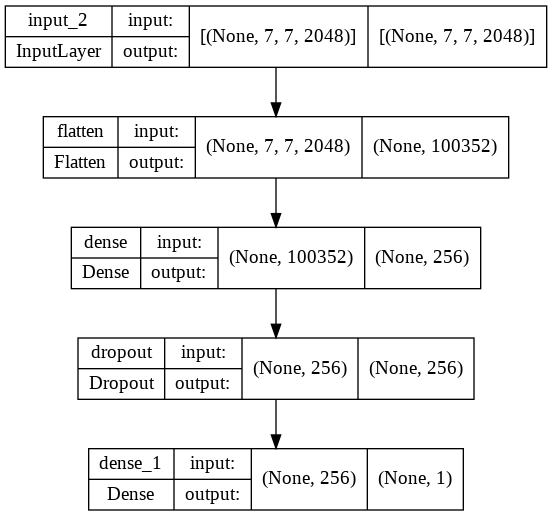

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7, 7, 2048)]      0         
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 25,690,625
Trainable params: 25,690,625
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(
  train_features, train_labels,
  epochs=10,
  validation_data=(val_features, val_labels))

Epoch 1/10
4/4 [==============================] - 2s 84ms/step - loss: 1.2239 - accuracy: 0.7700 - val_loss: 3.3223 - val_accuracy: 0.9200
Epoch 2/10
4/4 [==============================] - 0s 21ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 4.5329 - val_accuracy: 0.9200
Epoch 3/10
4/4 [==============================] - 0s 23ms/step - loss: 1.3097 - accuracy: 0.9600 - val_loss: 4.3285 - val_accuracy: 0.9400
Epoch 4/10
4/4 [==============================] - 0s 21ms/step - loss: 0.7499 - accuracy: 0.9700 - val_loss: 6.0990 - val_accuracy: 0.9600
Epoch 5/10
4/4 [==============================] - 0s 24ms/step - loss: 1.0875 - accuracy: 0.9800 - val_loss: 6.2760 - val_accuracy: 0.9600
Epoch 6/10
4/4 [==============================] - 0s 21ms/step - loss: 2.9712e-24 - accuracy: 1.0000 - val_loss: 6.1997 - val_accuracy: 0.9400
Epoch 7/10
4/4 [==============================] - 0s 21ms/step - loss: 2.4660e-21 - accuracy: 1.0000 - val_loss: 6.2963 - val_accuracy: 0.9400
Epoch 8/10
4/4 [===

In [ ]:
# handy function to visualize how the changes with each epoch

def plot_learning_curve(history):
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(accuracy) + 1)
  plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
  plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.show()

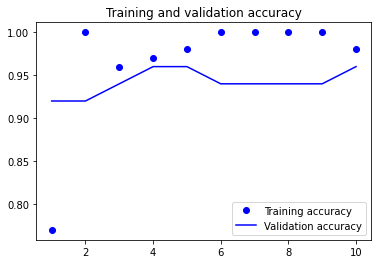

In [ ]:
plot_learning_curve(history)

In [ ]:
model.evaluate(test_features, test_labels)

3/3 [==============================] - 0s 7ms/step - loss: 0.8378 - accuracy: 0.9875


[0.8378375172615051, 0.987500011920929]

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
def predict_image(im):
  img = keras.preprocessing.image.load_img(im, target_size=(224,224))
  arr = keras.preprocessing.image.img_to_array(img)
  arr = keras.applications.resnet50.preprocess_input(arr)
  arr = np.expand_dims(arr, axis=0)
  arr = resnet50_base(arr)
  pred = model.predict(arr)
  pred = "nothing" if pred > 0.5 else "something"
  print("************************************\n\n")
  print(f"...........there is {pred}!")
  print("\n\n************************************\n\n")

Saved to /content/00_50_55_021_489.jpg


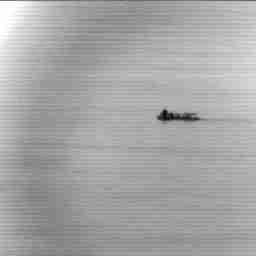

************************************


...........there is something!


************************************




In [ ]:
from IPython.display import Image
try:
  #I took files from the data set to test.
  filename = "/content/00_50_55_021_489.jpg"
  #filename = "/content/No_boat.jpg"
  #filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
  predict_image(filename)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))